In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'pandas'

In [2]:
time_int = 15
periods = 200
multiplier = 20
threshold = 1
bankroll = 15000
smooth = int(np.ceil(periods/2))

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
#contract = contract.loc['20180202':]
contract = contract.loc['20190401':]

In [4]:
contract

,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-04-01 00:00:00,7430.00,7438.75,7428.50,7437.25,733,7433.425,360
2019-04-01 00:01:00,7437.25,7450.00,7437.25,7449.50,1024,7443.075,607
2019-04-01 00:02:00,7449.00,7454.00,7446.00,7446.75,787,7449.625,380
2019-04-01 00:03:00,7447.00,7447.00,7445.25,7446.50,255,7446.275,138
2019-04-01 00:04:00,7446.75,7451.25,7446.50,7448.50,229,7448.900,143
...,...,...,...,...,...,...,...
2019-09-04 18:27:00,7695.50,7696.00,7694.75,7695.00,369,7695.475,178
2019-09-04 18:28:00,7695.00,7695.50,7694.75,7695.00,173,7695.025,72
2019-09-04 18:29:00,7695.00,7695.75,7694.50,7695.00,195,7695.125,87


In [5]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

4957.834123352981

In [6]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2019-04-01 00:21:00,7430.00,7454.50,7428.50,7454.25,2577,4920
1,2019-04-01 01:35:00,7454.00,7457.25,7448.25,7453.00,2949,5128
2,2019-04-01 02:08:00,7453.00,7469.25,7450.50,7466.50,3007,4866
3,2019-04-01 02:54:00,7466.75,7472.50,7462.25,7465.75,3241,5072
4,2019-04-01 03:49:00,7466.00,7475.75,7463.25,7473.00,3413,4931
...,...,...,...,...,...,...,...
9147,2019-09-04 17:39:00,7696.00,7702.25,7695.50,7697.75,2874,6151
9148,2019-09-04 17:51:00,7698.25,7703.00,7698.00,7699.75,2744,5482
9149,2019-09-04 18:04:00,7699.75,7704.25,7697.50,7703.25,2585,5426


In [7]:
time_candles = contract.resample('B').agg({'open': 'first',
                                         'high': 'max',
                                         'low': 'min',
                                         'close': 'last', 
                                         'barCount': 'sum',
                                         'volume': 'sum'})
data = pd.DataFrame({'open': vol_candles.open,
                     'close': vol_candles.close})

In [8]:
data['ema'] = data['close'].rolling(periods).mean()
data['bolli_upper'] = data['ema'] + (2 * data['ema'].rolling(periods).std())
data['bolli_lower'] = data['ema'] - (2 * data['ema'].rolling(periods).std())

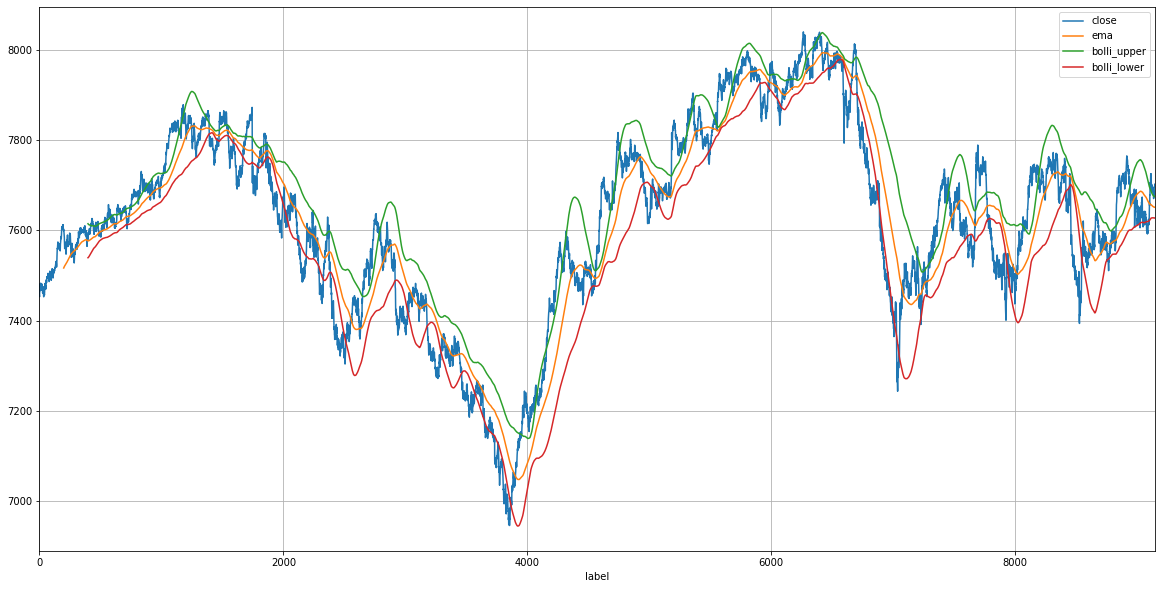

In [9]:
data[['close', 'ema', 'bolli_upper', 'bolli_lower']].plot(figsize=(20,10), grid=True);